In [1]:
from astropy.io.votable import from_table, parse_single_table
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
from scipy import interpolate

In [2]:
sns.set(style="whitegrid")
sns.set_context("paper")
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

## Produce a mean spectrum for the SMC
Create an inverse-noise weighted mean spectrum of the SMC

### Strategy

1. Select just the detections within the SMC as the sample
1. Establish a noise weighting scheme from the noise levels of each spectrum
    * See https://ned.ipac.caltech.edu/level5/Leo/Stats4_5.html
    * $\mu = \frac{\Sigma x_i/\sigma_i^2}{\Sigma 1/ \sigma_i^2}$
2. Scan all sample spectra:
  1. Read the spectrum
  2. Add the spectrum x the weighting to the mean spectrum
  3. Add the noise x the weighting to the mean noise
3. Plot the spectrum

In [3]:
spectra_table = parse_single_table('gaskap_smc_spectra.vot').to_table()
smc_filter = spectra_table['nh_gass'] >= 2E21
detections = spectra_table['has_other_abs']

sample_table = spectra_table[smc_filter & detections]
sample_table

id,comp_name,ra,dec,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,nh_gass,noise_flag,beam_power,nh_uncorr,e_nh_uncorr_high,e_nh_uncorr_low,nh_corr,e_nh_corr_high,e_nh_corr_low,r_hi,e_r_hi_high,e_r_hi_low,f_int,mean_ts,e_mean_ts_high,e_mean_ts_low,ew,e_ew_high,e_ew_low,num_chan
,,deg,deg,,mJy/beam,mJy/beam,,,,,,,km / s,,,,,arcsec,arcsec,deg,1 / cm2,,,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,,,,,,,,km / s,km / s,km / s,
int64,str32,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,bool,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13,J005535-723533,13.899411,-72.592574,C,15.053000450134277,8.522021817043423e-05,0.16227310227980046,1.856298565864563,2.5452221979121297,1.5236057043075562,93.0,-0.33269286155700684,113.61597766529509,5.0,3.6192534660730047,False,True,5.552000045776367,4.431999969482422,140.7100067138672,7.446596934360939e+21,False,0.9928809,7.168226876960794e+21,6.6340713476586996e+19,6.726331614813487e+19,8.843626276630882e+21,3.628476748811773e+20,3.239942397242387e+20,1.2322084922320404,0.05165155267252364,0.041606787784398636,1.175805883533249,528.7622807422028,205.8532701106077,124.8570289946307,15.716832512486212,3.9184702066876436,2.7463186491828586,94.0
19,J005448-725353,13.702572,-72.898137,C,15.98799991607666,0.00015485620824620127,0.18070838215007914,2.211228370666504,2.0076773559084584,1.7351946830749512,52.0,-0.4760337173938751,165.777135904169,5.0,3.821651016570783,False,True,3.8840000152587892,3.2680000305175785,137.1300048828125,6.945996611979021e+21,False,0.9740377,7.43866505345927e+21,6.504123039638723e+19,8.075688737587593e+19,9.80242498981033e+21,4.4323439703317126e+20,3.79623438977027e+20,1.3185782469928635,0.05525418791045089,0.04871039028888724,1.2337775557312536,223.98136174446972,40.35793460826085,28.02550154051221,29.100345322252238,5.131243000970013,3.141677521129128,106.0
26,J010532-721331,16.386939,-72.225495,C,16.305999755859375,0.00013356159906834363,0.20625884450647666,1.7323534488677979,1.4747387200154491,1.7000147104263306,105.0,-0.03233879804611206,132.31849058601603,5.0,3.59348986463798,False,True,3.7759998321533206,3.2279998779296877,138.6999969482422,4.38220123668127e+21,False,1.0038936,4.440652468391023e+21,7.217859007982915e+19,7.817343194310692e+19,5.380515604114043e+21,3.031127946684321e+20,2.3686521300457095e+20,1.2121622099137705,0.06286574531619071,0.048027218582256115,1.1504229722489532,358.4004933379822,221.95500054437957,98.21608337616271,15.905849428449196,4.524592227857476,3.146504087541345,90.0
33,J005014-730326,12.561714,-73.057288,C,16.516000747680664,0.00013204875867813825,0.19689896771242069,1.833931803703308,1.7889600056779422,1.657568335533142,83.0,-0.17636345326900482,156.91375551519,5.0,3.878704994296605,False,True,4.231999969482422,3.7040000915527345,124.37999725341797,9.285400120443429e+21,False,0.98851216,1.0307584032510973e+22,8.14803393800768e+19,7.749701068357265e+19,1.2700597355956283e+22,4.933249604324174e+20,4.573327253481162e+20,1.2331764335373825,0.04435337172582843,0.0450013346247049,1.157342694331896,481.75022941069574,146.68927904157601,97.29383142071788,23.399996845350465,5.104531576081085,3.5029318221153996,105.0
65,J010556-714607,16.485762,-71.768701,B,18.34600067138672,9.685506811365485e-05,0.0913800614643391,0.9039841890335083,1.442422298692272,1.3701179027557373,119.0,0.4661336839199066,148.08679154207204,0.763282835483551,0.22327868834925058,False,True,8.627999877929687,4.079999923706055,51.0099983215332,4.966179567806026e+21,False,1.0041966,5.160743275895109e+21,7.546584750513612e+19,7.086194478769242e+19,6.063113695389413e+21,1.4884537932157498e+20,1.3679223843038796e+20,1.1728306675864042,0.

In [18]:
def weight_spectrum(spectrum, weight):
    return spectrum * weight

def build_mean_spectrum(abs_sample_table, weights, spectrum_key='opacity', noise_key='sigma_opacity', velocity=None):
    tot_weight = np.sum(weights)

    total_spectrum = None
    noise_spectrum = None
    velocity = None
    for idx, comp_name in enumerate(abs_sample_table['comp_name']):
        if idx % 50 == 0:
            print ('processing record {} of {}'.format(idx+1, len(abs_sample_table)))
            
        spec_file_name = 'sb10944/v3a/spectra/{}_spec.vot'.format(comp_name)
        spec = parse_single_table(spec_file_name).to_table()
        if velocity is None:
            velocity = np.array(spec['velocity'])
            
        f = interpolate.interp1d(np.array(spec['velocity']), np.array(spec[spectrum_key]), fill_value=1, bounds_error=False, kind='cubic')
        regridded_spec = f(velocity)
        weighted_spectrum = weight_spectrum(regridded_spec, weights[idx])
        if total_spectrum is None:
            total_spectrum = weighted_spectrum
        else:
            total_spectrum += weighted_spectrum
            
        f = interpolate.interp1d(spec['velocity'], spec[noise_key], fill_value=0, bounds_error=False, kind='cubic')
        regridded_noise_spec = f(velocity)
        #src_noise_spectrum = weight_spectrum(regridded_noise_spec, weights[idx])
        src_noise_spectrum = weight_spectrum(regridded_noise_spec, weights[idx]/tot_weight)**2

        if noise_spectrum is None:
            noise_spectrum = src_noise_spectrum
        else:
            noise_spectrum += src_noise_spectrum
    
    mean_spectrum = total_spectrum/tot_weight
    #mean_noise = noise_spectrum/tot_weight
    mean_noise = np.sqrt(noise_spectrum)
    return mean_spectrum, mean_noise, velocity
    

In [5]:
def plot_abs_spectrum(velocity, opacity, sigma_opacity, filename, title, vel_range=None, ranges=None):
    fig, ax = plt.subplots(1, 1, figsize=(4, 5))
    
    ax.set_title(title) #, fontsize=16)

    ax.axhline(1, color='r')
    ax.plot(velocity, opacity, zorder=4, lw=0.8, color='black')
    ax.fill_between(velocity, 1-sigma_opacity, 1+sigma_opacity, color='grey', alpha=0.6, zorder=1)
    ax.plot(velocity, 1-(3*sigma_opacity), zorder=1, lw=2, ls=":", color='orange')
    ax.set_ylabel(r'Absorption ($e^{-\tau})$')#, fontsize=14)
    ax.grid(True)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', direction='in', bottom=True, top=True)
    
    if vel_range is None:
        vel_range = (np.min(velocity), np.max(velocity))
    ax.set_xlim(vel_range)

    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()
    return

def plot_combined_spectrum(velocity, em_mean, em_std, opacity, sigma_opacity, filename, title, vel_range=None, ranges=None):
    fig, axs = plt.subplots(2, 1, figsize=(4, 5))
    
    axs[0].set_title(title) #, fontsize=16)

    axs[0].axhline(1, color='r')
    axs[0].plot(velocity, opacity, zorder=4, lw=0.8, color='black')
    axs[0].fill_between(velocity, 1-sigma_opacity, 1+sigma_opacity, color='grey', alpha=0.6, zorder=1)
    axs[0].plot(velocity, 1-(3*sigma_opacity), zorder=1, lw=2, ls=":", color='orange')
    axs[0].set_ylabel(r'Absorption ($e^{-\tau})$')#, fontsize=14)
    axs[0].grid(True)

    axs[0].xaxis.set_minor_locator(AutoMinorLocator())
    axs[0].tick_params(which='both', direction='in', bottom=True, top=True)

    axs[1].plot(velocity, em_mean, color='black', zorder=4, lw=1)
    axs[1].fill_between(velocity, em_mean-em_std, em_mean+em_std, color='grey', alpha=0.8, zorder=1)
    axs[1].set_ylabel(r'Brightness Temp (K)')#, fontsize=14)
    axs[1].set_xlabel(r'Velocity relative to LSRK (km/s)') #, fontsize=14)
    axs[1].grid(True)

    axs[1].xaxis.set_minor_locator(AutoMinorLocator())
    axs[1].tick_params(which='both', direction='in', bottom=True, top=True)
    
    if vel_range is None:
        vel_range = (np.min(velocity), np.max(velocity))
    axs[0].set_xlim(vel_range)
    axs[1].set_xlim(vel_range)

    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()
    return



processing record 1 of 48


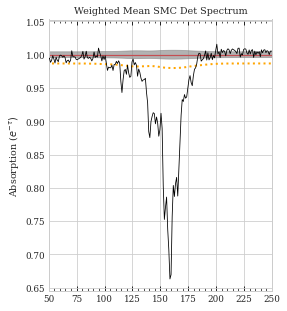

In [19]:
exclude_pair = (spectra_table['comp_name'] != 'J011050-731426') #& (spectra_table['comp_name'] != 'J011049-731428')

sample_table = spectra_table[smc_filter & detections & exclude_pair]

weights = 1/(sample_table['sd_cont']**2)

mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

plot_abs_spectrum(velocity/1000, mean_spectrum, mean_noise, 'figures/mean_spectrum1.pdf', 
              'Weighted Mean SMC Det Spectrum', vel_range=(50,250))

processing record 1 of 83
processing record 51 of 83


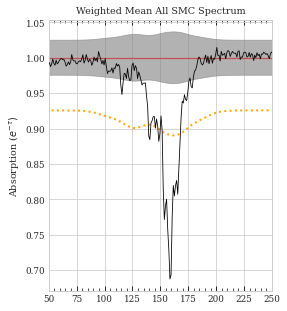

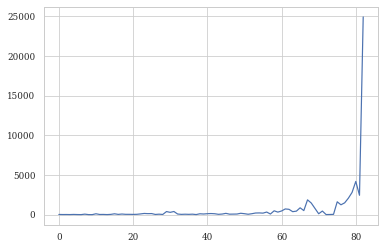

In [11]:
sample_table = spectra_table[smc_filter & exclude_pair]

weights = 1/(sample_table['sd_cont']**2)
mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

plot_abs_spectrum(velocity/1000, mean_spectrum, mean_noise, 'figures/mean_spectrum_smc_all.pdf', 
              'Weighted Mean All SMC Spectrum', vel_range=(50,250))
plt.plot(weights)

processing record 1 of 65
processing record 51 of 65


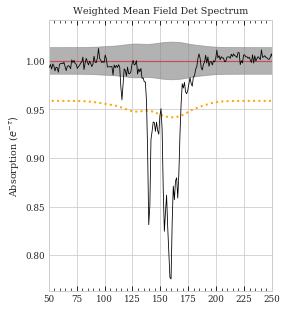

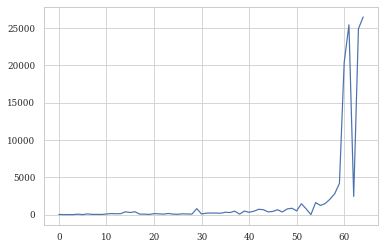

In [40]:
sample_table = spectra_table[detections]

weights = 1/(sample_table['sd_cont']**2)
mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

plot_abs_spectrum(velocity/1000, mean_spectrum, mean_noise, 'figures/mean_spectrum_field.pdf', 
              'Weighted Mean Field Det Spectrum', vel_range=(50,250))
plt.plot(weights)

processing record 1 of 229
processing record 51 of 229
processing record 101 of 229
processing record 151 of 229
processing record 201 of 229


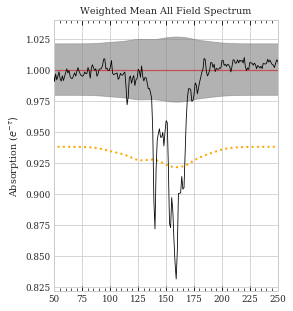

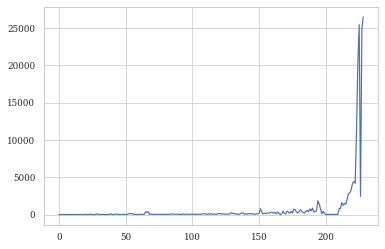

In [41]:
sample_table = spectra_table

weights = 1/(sample_table['sd_cont']**2)
mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

plot_abs_spectrum(velocity/1000, mean_spectrum, mean_noise, 'figures/mean_spectrum_field_all.pdf', 
              'Weighted Mean All Field Spectrum', vel_range=(50,250))
plt.plot(weights)

processing record 1 of 49


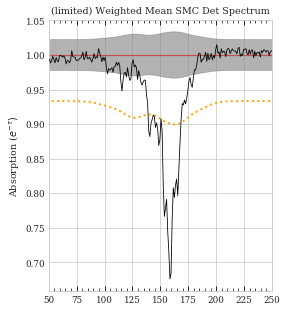

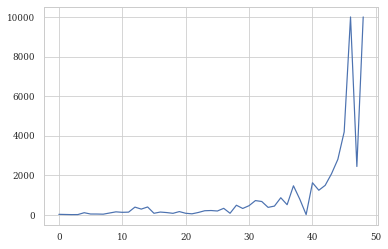

In [42]:
sample_table = spectra_table[smc_filter & detections]

weights = 1/(sample_table['sd_cont']**2)
weights = np.minimum(10000, weights)

mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

plot_abs_spectrum(velocity/1000, mean_spectrum, mean_noise, 'figures/mean_spectrum_limit_weights.pdf', 
              '(limited) Weighted Mean SMC Det Spectrum', vel_range=(50,250))
plt.plot(weights)

processing record 1 of 83
processing record 51 of 83
processing record 1 of 83
processing record 51 of 83


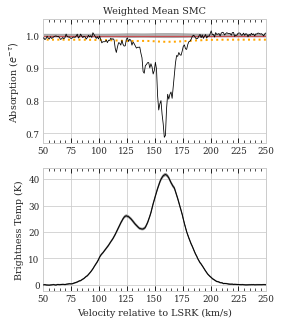

In [50]:
sample_table = spectra_table[smc_filter & exclude_pair]

weights = 1/(sample_table['sd_cont']**2)
mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

#weights = 1/(sample_table['sd_cont']**2)
weights = np.ones(len(sample_table))
mean_em_spectrum, mean_em_noise, velocity = build_mean_spectrum(sample_table, weights, spectrum_key='em_mean', noise_key='em_std', velocity=velocity)

plot_combined_spectrum(velocity/1000, mean_em_spectrum, mean_em_noise, mean_spectrum, mean_noise, 'figures/em_mean_spectrum_smc_all_weighted.pdf', 
              'Weighted Mean SMC', vel_range=(50,250))
                       
#plot_abs_spectrum(spec['velocity']/1000, mean_em_spectrum, mean_em_noise, 'em_mean_spectrum_smc_all.pdf', 
#              'Weighted Mean All SMC Spectrum', vel_range=(50,250))

processing record 1 of 43
processing record 1 of 43


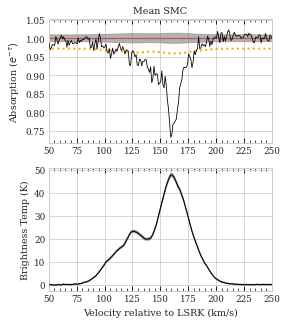

In [52]:
noise_filter = spectra_table['sd_cont'] <= 0.10
sample_table = spectra_table[smc_filter & noise_filter & exclude_pair]

#weights = 1/(sample_table['sd_cont']**2)
weights = np.ones(len(sample_table))

mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

#weights = 1/(sample_table['sd_cont']**2)
weights = np.ones(len(sample_table))
mean_em_spectrum, mean_em_noise, velocity = build_mean_spectrum(sample_table, weights, spectrum_key='em_mean', noise_key='em_std', velocity=velocity)

plot_combined_spectrum(velocity/1000, mean_em_spectrum, mean_em_noise, mean_spectrum, mean_noise, 'figures/em_mean_spectrum_smc_all.pdf', 
              'Mean SMC', vel_range=(50,250))
                       
#plot_abs_spectrum(spec['velocity']/1000, mean_em_spectrum, mean_em_noise, 'em_mean_spectrum_smc_all.pdf', 
#              'Weighted Mean All SMC Spectrum', vel_range=(50,250))

[18.76276897 18.80835256 18.85375086 18.91509571 18.96522008 19.01748306
 19.06201382 19.11127518 19.14793376 19.18234006 19.22183711 19.25498442
 19.2768847  19.29002721 19.30663875 19.32603181 19.34362652 19.36217276
 19.3801154  19.39940245 19.41878308 19.4322112  19.44276023 19.45780606
 19.46579069 19.47510471 19.48520821 19.4979322  19.51586817 19.53978109
 19.56038285 19.57866419 19.59914798 19.61337686 19.62356344 19.62585115
 19.62747932 19.6228356  19.62021614 19.61483512 19.60874735 19.60142791
 19.5929348  19.58569993 19.57617793 19.56714385 19.559386   19.55705168
 19.55760764 19.5583688  19.56204841 19.56706904 19.58285395 19.60165502
 19.6252994  19.65137959 19.67487201 19.70505289 19.73604487 19.76201825
 19.78698445 19.8111763  19.83360661 19.85523052 19.87388777 19.8922549
 19.90684293 19.9196591  19.92986858 19.93821399 19.93915971 19.93555059
 19.92812152 19.91954096 19.90860759 19.89762673 19.88603068 19.8789509
 19.86549213 19.84880381 19.83441851 19.81599419 19.7

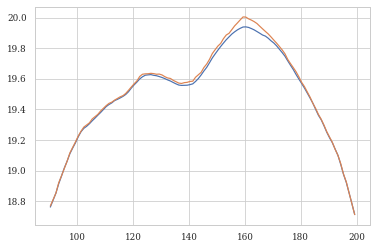

In [114]:
c0 = 1.823 * 10**18
vel_filter = (velocity/1000 >= 90) & (velocity/1000 <= 200)
em_values = mean_em_spectrum[vel_filter]
abs_values = mean_spectrum[vel_filter]

nh_uncorr = c0 * em_values
no_abs_filter = (abs_values == 1)
tau = -1*np.log(abs_values)
nh_corr = c0 * tau*em_values / (1-abs_values)
nh_corr[no_abs_filter] = c0*em_values[no_abs_filter] # Fixes the div by 0 channels where there is no absorption

plt.plot(velocity[vel_filter]/1000, np.log10(nh_uncorr))
plt.plot(velocity[vel_filter]/1000, np.log10(nh_corr))
print(np.log10(nh_uncorr))

total r_HI = 1.06


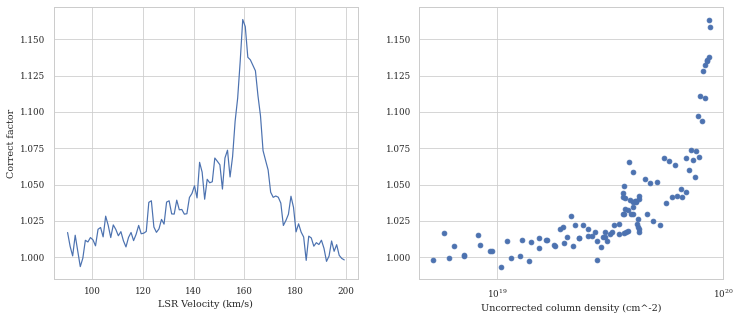

In [115]:
r_hi = nh_corr / nh_uncorr
total_r_hi = np.sum(nh_corr) / np.sum(nh_uncorr)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(velocity[vel_filter]/1000, r_hi)
ax1.set_xlabel("LSR Velocity (km/s)")
ax1.set_ylabel("Correct factor")
               
ax2.scatter(nh_uncorr, r_hi)
ax2.set_xscale("log", nonpositive='clip')
ax2.set_xlabel("Uncorrected column density (cm^-2)")


print ('total r_HI = {:.2f}'.format(total_r_hi))

/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_9436/3769154820.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1a.set_yticklabels(['', '', '30', '3'])


total <T_S> = 319.91 and cold gas fraction = 9.4%
At 159 km/s there is 16.9% cold gas at T_B=47.58
At 160 km/s there is 16.4% cold gas at T_B=47.68
At 125 km/s there is 4.3% cold gas at T_B=23.18
At 124 km/s there is 5.3% cold gas at T_B=23.06
At 142 km/s there is 17.1% cold gas at T_B=20.99
At 175 km/s there is 4.4% cold gas at T_B=28.65


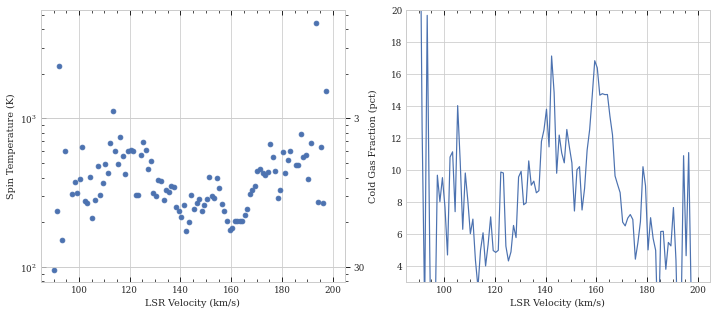

In [118]:
tot_em = em_values
tot_od = 1-abs_values
mean_ts = tot_em / tot_od

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12,5))

ax1.scatter(velocity[vel_filter]/1000, mean_ts)
ax1.set_yscale("log", nonpositive='clip')

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', direction='in', bottom=True, top=True)
ax1.set_ylabel("Spin Temperature (K)")
ax1.set_xlabel("LSR Velocity (km/s)")


#ax1.yaxis.tick_right()
ax1a = ax1.twinx()
y_range = ax1.get_ylim() #30/np.array(ax1.get_ylim())*100
ax1a.set_ylim(y_range)
#ax1.scatter(velocity[vel_filter]/1000, 30/mean_ts)
ax1a.set_yscale("log", nonpositive='clip')
ax1a.set_yticklabels(['', '', '30', '3'])
ax1a.set_ylabel("Cold Gas Fraction (pct)")
#ax

ax2.plot(velocity[vel_filter]/1000, 30/mean_ts*100)
ax2.set_ylim((3, 20))

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='both', direction='in', bottom=True, top=True)
ax2.set_xlabel("LSR Velocity (km/s)")

plt.savefig('figures/mean_spectrum_cold_gas_fraction.png', bbox_inches='tight')

total_mean_ts = np.sum(tot_em) / np.sum(tot_od)
total_cold_gas_fraction = 30 / (total_mean_ts)
print ('total <T_S> = {:.2f} and cold gas fraction = {:.1f}%'.format(total_mean_ts, 100*total_cold_gas_fraction))

sample_vels = [159, 160, 125, 124, 142, 175]
for vel in sample_vels:
    idx = np.searchsorted(velocity[vel_filter]/1000, vel, side="left")
    print ("At {:.0f} km/s there is {:.1f}% cold gas at T_B={:.2f}".format(vel, 30/mean_ts[idx]*100, em_values[idx]))

In [121]:
primary_vels = (velocity[vel_filter]/1000 >= 155) & (velocity[vel_filter]/1000 <= 165)
total_mean_ts = np.sum(tot_em[primary_vels]) / np.sum(tot_od[primary_vels])
total_cold_gas_fraction = 30 / (total_mean_ts)
print ('Primary Em peak - total <T_S> = {:.2f} and cold gas fraction = {:.1f}%'.format(total_mean_ts, 100*total_cold_gas_fraction))

secondary_vels = (velocity[vel_filter]/1000 >= 120) & (velocity[vel_filter]/1000 <= 130)
total_mean_ts = np.sum(tot_em[secondary_vels]) / np.sum(tot_od[secondary_vels])
total_cold_gas_fraction = 30 / (total_mean_ts)
print ('Secondary Em peak - total <T_S> = {:.2f} and cold gas fraction = {:.1f}%'.format(total_mean_ts, 100*total_cold_gas_fraction))



Primary Em peak - total <T_S> = 214.01 and cold gas fraction = 14.0%
Secondary Em peak - total <T_S> = 454.47 and cold gas fraction = 6.6%


### Scratch

processing record 1 of 21
processing record 1 of 21


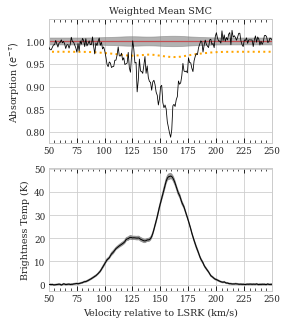

In [46]:
noise_filter = spectra_table['sd_cont'] < 0.05
sample_table = spectra_table[smc_filter & noise_filter & exclude_pair]

#weights = 1/(sample_table['sd_cont']**2)
weights = np.ones(len(sample_table))

mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

#weights = 1/(sample_table['sd_cont']**2)
weights = np.ones(len(sample_table))
mean_em_spectrum, mean_em_noise, velocity = build_mean_spectrum(sample_table, weights, spectrum_key='em_mean', noise_key='em_std', velocity=velocity)

plot_combined_spectrum(velocity/1000, mean_em_spectrum, mean_em_noise, mean_spectrum, mean_noise, 'figures/em_mean_spectrum_smc_all_bright.pdf', 
              'Weighted Mean SMC', vel_range=(50,250))
                       
#plot_abs_spectrum(spec['velocity']/1000, mean_em_spectrum, mean_em_noise, 'em_mean_spectrum_smc_all.pdf', 
#              'Weighted Mean All SMC Spectrum', vel_range=(50,250))

In [37]:
weights = 1/(sample_table['sd_cont']**2)
order = np.argsort(weights)
for i in range(-1,-20,-1):
    print ('{} {:>5.0f}'.format(sample_table['comp_name'][order][i], weights[order][i]))
#print (weights[order][-20:])


J011050-731426 25437
J011049-731428 24909
J003824-742212  4199
J005218-722708  2812
J011056-731407  2452
J011432-732143  2085
J010932-713453  1876
J010029-713826  1632
J003809-735024  1500
J010930-713456  1479
J011005-722648  1253
J004956-723554   875
J005238-731245   801
J004226-730418   732
J011132-730210   686
J005556-722605   524
J011610-733900   497
J012639-731502   475
J003754-725157   466


processing record 1 of 84
processing record 51 of 84
processing record 1 of 84
processing record 51 of 84


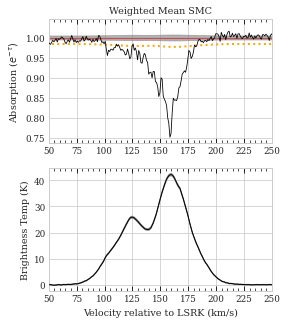

In [26]:
sample_table = spectra_table[smc_filter]

weights = np.minimum(2000,1/(sample_table['sd_cont']**2))
sorted(weights)
mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

#weights = 1/(sample_table['sd_cont']**2)
weights = np.ones(len(sample_table))
mean_em_spectrum, mean_em_noise, velocity = build_mean_spectrum(sample_table, weights, spectrum_key='em_mean', noise_key='em_std', velocity=velocity)

plot_combined_spectrum(velocity/1000, mean_em_spectrum, mean_em_noise, mean_spectrum, mean_noise, 'figures/em_mean_spectrum_smc_all_both_pair_capped.pdf', 
              'Weighted Mean SMC', vel_range=(50,250))



processing record 1 of 229
processing record 51 of 229
processing record 101 of 229
processing record 151 of 229
processing record 201 of 229
processing record 1 of 229
processing record 51 of 229
processing record 101 of 229
processing record 151 of 229
processing record 201 of 229


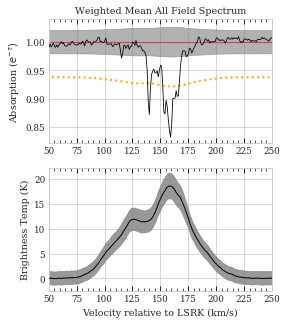

In [44]:
sample_table = spectra_table

weights = 1/(sample_table['sd_cont']**2)
mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

#weights = 1/(sample_table['sd_cont']**2)
weights = np.ones(len(sample_table))
mean_em_spectrum, mean_em_noise, velocity = build_mean_spectrum(sample_table, weights, spectrum_key='em_mean', noise_key='em_std', velocity=velocity)

plot_combined_spectrum(velocity/1000, mean_em_spectrum, mean_em_noise, mean_spectrum, mean_noise, 'figures/em_mean_spectrum_field_all.pdf', 
              'Weighted Mean All Field Spectrum', vel_range=(50,250))
                       
#plot_abs_spectrum(spec['velocity']/1000, mean_em_spectrum, mean_em_noise, 'em_mean_spectrum_smc_all.pdf', 
#              'Weighted Mean All SMC Spectrum', vel_range=(50,250))

#### Rings of column density

0 1e+20
processing record 1 of 22
processing record 1 of 22


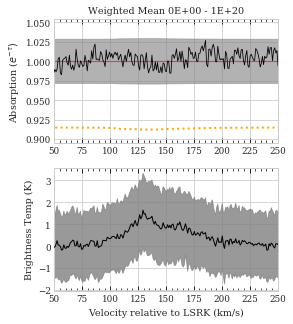

1e+20 5e+20
processing record 1 of 43
processing record 1 of 43


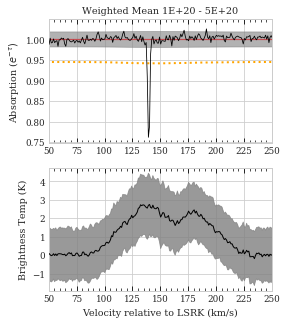

5e+20 1e+21
processing record 1 of 27
processing record 1 of 27


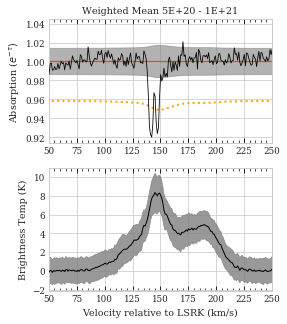

1e+21 2e+21
processing record 1 of 58
processing record 51 of 58
processing record 1 of 58
processing record 51 of 58


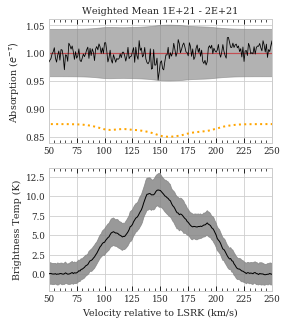

2e+21 5e+22
processing record 1 of 79
processing record 51 of 79
processing record 1 of 79
processing record 51 of 79


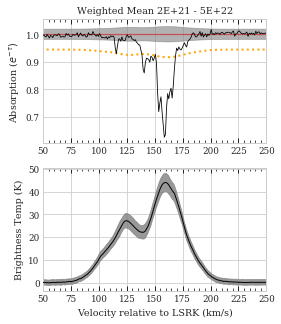

In [45]:
thresholds = [1e20, 5e20, 1e21, 2e21, 5e22]
low_limit = 0
for idx, high_limit in enumerate(thresholds):
    print (low_limit, high_limit)
    
    nh_filter = (spectra_table['nh_uncorr'] >= low_limit) & (spectra_table['nh_uncorr'] < high_limit)
    sample_table = spectra_table[nh_filter]

    weights = 1/(sample_table['sd_cont']**2)
    mean_spectrum, mean_noise, velocity = build_mean_spectrum(sample_table, weights)

    #weights = 1/(sample_table['sd_cont']**2)
    weights = np.ones(len(sample_table))
    mean_em_spectrum, mean_em_noise, velocity = build_mean_spectrum(sample_table, weights, spectrum_key='em_mean', noise_key='em_std', velocity=velocity)

    plot_combined_spectrum(velocity/1000, mean_em_spectrum, mean_em_noise, mean_spectrum, mean_noise, 
                           'figures/mean_spec_field_ring_{}.pdf'.format(idx+1), 
                           'Weighted Mean {:.0E} - {:.0E}'.format(low_limit, high_limit), vel_range=(50,250))


    low_limit = high_limit